# Robust and Rapid Surface Normal Estimation from Disparities of Rectified Stereo Images via Affine Transformations

PyOpenGL, PyCUDA, or CuPy

In [1]:
import numpy as np
from scipy.ndimage import map_coordinates
import cv2
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D

## Params

In [2]:
MAX_ADAPTIVE_DIRS = 32

disparities = np.zeros((100, 100, 1))  
weights = np.zeros((100, 100, 2))      
depth = np.zeros((100, 100, 3))        
resolution = np.array([100, 100])

conv1 = np.zeros(15 * 15)
conv2 = np.zeros(15 * 15)
v = np.zeros((15 * 15, 2))

conv_size = 3
adaptive_simple_thresh = 1.0
adaptive_cumulative_thresh = 1.0
adaptive_depth_thresh_ratio = 0.1
costhresh = np.cos(np.radians(20))
ang_min_steps = 3
adaptive_dir_count = 8 # old 8
adaptive_dirs = np.random.rand(MAX_ADAPTIVE_DIRS, 2)  
adaptive_max_step_count = 5 # old 5

mode = 0

## Methods

In [3]:
def texture(tex, uv, ch=None):
    """
    Bilinear sample at normalized uv (any real values allowed).
    Clamps to [0,1] → CLAMP_TO_EDGE like GLSL.
    Returns a Python float.
    """
    h, w = tex.shape[:2]

    # clamp uv to [0,1] to emulate GL_CLAMP_TO_EDGE
    u = float(np.clip(uv[0], 0.0, 1.0))
    v = float(np.clip(uv[1], 0.0, 1.0))

    # map to pixel coordinates in [0, w-1] and [0, h-1]
    x = u * (w - 1)
    y = v * (h - 1)

    x0 = int(np.floor(x)); x1 = min(x0 + 1, w - 1)
    y0 = int(np.floor(y)); y1 = min(y0 + 1, h - 1)
    xf = x - x0
    yf = y - y0

    if tex.ndim == 2:
        v00 = float(tex[y0, x0]); v10 = float(tex[y0, x1])
        v01 = float(tex[y1, x0]); v11 = float(tex[y1, x1])
    else:
        c = 0 if ch is None else int(ch)
        v00 = float(tex[y0, x0, c]); v10 = float(tex[y0, x1, c])
        v01 = float(tex[y1, x0, c]); v11 = float(tex[y1, x1, c])

    top = v00*(1 - xf) + v10*xf
    bot = v01*(1 - xf) + v11*xf
    return top*(1 - yf) + bot*yf

    

def affine_nb(center, pxsize, image, disparity):
    dc = -texture(disparity, center)
    dr = -texture(disparity, center + np.array([pxsize[0], 0]))
    dt = -texture(disparity, center + np.array([0, pxsize[1]]))

    scale = (1 - dr + dc)
    shear = (dt - dc)
    return np.array([scale, shear])


# def affine_lsq(center, pxsize, image, disparity):
#     dc = -texture(disparity, center)
#     affine = np.array([0.0, 0.0])
#     for i in range(conv_size):
#         d = -texture(disparity, center + v[i] * pxsize)
#         d -= dc  
#         affine[0] += d * conv1[i]
#         affine[1] += d * conv2[i]
#     affine[0] =  (1 - affine[0])  
#     return affine
    
def affine_lsq(center, pxsize, disparities):
    dc = -texture_scalar(disparities, center)
    a0 = 0.0; a1 = 0.0
    for i in range(conv_size):
        # v[i] is in pixel units, pxsize = (1/W, 1/H)
        offset = center + v[i] * pxsize
        d = -texture_scalar(disparities, offset)
        d -= dc
        a0 += d * conv1[i]
        a1 += d * conv2[i]
    a0 = 1.0 - a0
    return np.array([a0, a1], dtype=np.float32)


def weight(pos, weights):
    lap = np.abs(texture(weights, pos))
    return lap


In [4]:
#ST (Simple Threshold)
def adaptive_affine_simple_threshold(center, pxsize, image, disparity, weights):
    a, b, c = 0, 0, 0
    ends = np.zeros(adaptive_dir_count, dtype=int)
    for i in range(adaptive_dir_count):
        k = 0
        pos = np.array([0.0, 0.0])
        while k < adaptive_max_step_count:
            a += pos[0] * pos[0]
            b += pos[0] * pos[1]
            c += pos[1] * pos[1]
            pos += adaptive_dirs[i]
            d = texture(disparity, center + pos * pxsize)
            if np.linalg.norm(weight(center + pos * pxsize, weights)) >= adaptive_simple_thresh * d:
                break
            k += 1
        ends[i] = k

    D = a * c - b * b

    if np.abs(D) < 1e-10:
        return affine_nb(center, pxsize, image, disparity)
    else:
        dc = -texture(disparity, center)
        affine = np.array([0.0, 0.0])
        inv = 1 / D 
        for i in range(adaptive_dir_count):
            pos = np.array([0.0, 0.0])
            for j in range(ends[i]):
                d = -texture(disparity, center + pos * pxsize)
                d -= dc
                affine[0] += d * (pos[0] * c - pos[1] * b) * inv
                affine[1] += d * (-pos[0] * b + pos[1] * a) * inv
                pos += adaptive_dirs[i]

        affine[0] = 1 - affine[0]
        return affine

  
def adaptive_affine_cumulative_error_lsq(center, pxsize, image, disparity, weights):
    a, b, c = 0, 0, 0
    ends = np.zeros(adaptive_dir_count, dtype=int)

    for i in range(adaptive_dir_count):
        k = 0
        pos = np.array([0.0, 0.0])
        w = weight(center, weights)
        lastw = np.array([0.0, 0.0])
        
        while k < adaptive_max_step_count and np.linalg.norm(w) < adaptive_cumulative_thresh:
            a += pos[0] * pos[0]
            b += pos[0] * pos[1]
            c += pos[1] * pos[1]
            pos += adaptive_dirs[i]
            lastw = weight(center + pos * pxsize, weights)
            w += lastw
            k += 1
        ends[i] = k

    D = a * c - b * b

    if np.abs(D) < 1e-10:
        return affine_nb(center, pxsize, image, disparity)
    else:
        dc = -texture(disparity, center)
        affine = np.array([0.0, 0.0])
        inv = 1 / D
        
        for i in range(adaptive_dir_count):
            pos = np.array([0.0, 0.0])
            for j in range(ends[i]):
                d = -texture(disparity, center + pos * pxsize)
                d -= dc
                affine[0] += d * (pos[0] * c - pos[1] * b) * inv
                affine[1] += d * (-pos[0] * b + pos[1] * a) * inv
                pos += adaptive_dirs[i]

        affine[0] = 1 - affine[0]
        return affine

In [5]:
#CD (Covered Depth)
def adaptive_affine_lsq_min_max(center, pxsize, image, disparity, depth):
    # print(f"[START] center={center}")                # ← entry log
    a = b = c = 0.0
    d_o     = texture(depth, center)
    # d_o = depth
    d_thresh = d_o * adaptive_depth_thresh_ratio

    # —— FIRST PASS: accumulate a,b,c ——
    for i in range(adaptive_dir_count):
        # print(f"  [PASS1] dir {i}")                  # ← entering direction i
        k = 0
        pos = np.array([0.0, 0.0])
        d_min, d_max = d_o, d_o
        while k < adaptive_max_step_count and (d_max - d_min) < d_thresh:
            # occasional log inside the while
            # if k % 5 == 0:
                # print(f"    pass1: k={k}, pos={pos}, d_min={d_min:.4f}, d_max={d_max:.4f}")
            a += pos[0] * pos[0]
            b += pos[0] * pos[1]
            c += pos[1] * pos[1]
            pos += adaptive_dirs[i] * np.sqrt(2)
            d = texture(depth, center + pos * pxsize)
            # d = depth
            d_min = min(d_min, d)
            d_max = max(d_max, d)
            k += 1
        # print(f"  [PASS1] dir {i} done after {k} steps")

    D = a * c - b * b
    # print(f"  [DET] D={D:.6e}")

    if np.abs(D) < 1e-10:
        # print("  [FALLBACK] singular matrix, using affine_nb")
        return affine_nb(center, pxsize, image, disparity)
    else:
        # —— SECOND PASS: fit disparity ——
        dc = -texture(disparity, center)
        # print(f"  [PASS2] dc={dc:.6f}")
        affine = np.array([0.0, 0.0])
        inv = 1.0 / D
    
        for i in range(adaptive_dir_count):
            # print(f"  [PASS2] dir {i}")
            k = 0
            pos = np.array([0.0, 0.0])
            d_min, d_max = d_o, d_o
            while k < adaptive_max_step_count: #and (d_max - d_min) < d_thresh:
                # if k % 5 == 0:
                    # print(f"    pass2: k={k}, pos={pos}")
                disp = -texture(disparity, center + pos * pxsize)
                disp -= dc
                affine[0] += disp * (pos[0] * c - pos[1] * b) * inv
                affine[1] += disp * (-pos[0] * b + pos[1] * a) * inv
                pos += adaptive_dirs[i] * np.sqrt(2)
                d = texture(depth, center + pos * pxsize)
                # d = depth
                d_min = min(d_min, d)
                d_max = max(d_max, d)
                if (d_max - d_min) >= d_thresh:
                    break
                k += 1
            # print(f"  [PASS2] dir {i} done after {k} steps")
    
        affine[0] = 1.0 - affine[0]
        # print(f"[END] center={center} affine={affine}")
        return affine



def adaptive_affine_angular_threshold(center, pxsize, image, disparity, depth):
    ends = np.zeros(adaptive_dir_count, dtype=int)
    cd = texture(depth, center) 

    for i in range(adaptive_dir_count):
        pos = np.array([0.0, 0.0])
        k = 1
        sum_vec = np.array([0.0, 0.0, 0.0])
        pos += adaptive_dirs[i]
        sum_vec += texture(depth, center + pos * pxsize)[:3] - cd[:3]
        cosang = 1.0

        d = np.array([0.0, 0.0, 0.0])
        # First pass
        while k <= adaptive_max_step_count and (k < ang_min_steps or cosang > costhresh):
            sum_vec += d
            pos += adaptive_dirs[i]
            k += 1
            d = texture(depth, center + pos * pxsize)[:3] - cd[:3]
            avg = sum_vec
            cur = d
            cosang = np.dot(avg / np.linalg.norm(avg), cur / np.linalg.norm(cur))

        ends[i] = k - 1

        # Second pass to find the best index
        pos = np.array([0.0, 0.0])
        maxcos = -2.0
        bestidx = 0
        leftsum = np.array([0.0, 0.0, 0.0])
        endp = texture(depth, center + pos * pxsize * ends[i])[:3]
        for j in range(1, ends[i]):
            d = texture(depth, center + adaptive_dirs[i] * j * pxsize)[:3] - cd[:3]

            # Current is included on both sides (avoiding zero vectors at start)
            rightsum = sum_vec - leftsum
            leftsum += d

            avgleft = leftsum
            cur = d
            cosleft = np.dot(avgleft / np.linalg.norm(avgleft), cur)
            avgright = rightsum - endp * (ends[i] - j)
            curright = cur - endp
            cosright = np.dot(avgright / np.linalg.norm(avgright), curright / np.linalg.norm(curright))
            totalcos = cosleft + cosright
            if totalcos > maxcos:
                maxcos = totalcos
                bestidx = j

        ends[i] = bestidx - 1

    a, b, c = 0, 0, 0
    for i in range(adaptive_dir_count):
        for j in range(ends[i] + 1):
            pos = adaptive_dirs[i] * j
            a += pos[0] * pos[0]
            b += pos[0] * pos[1]
            c += pos[1] * pos[1]

    dispc = -texture(disparity, center)#[0]
    affine = np.array([0.0, 0.0])
    inv = 1 / (a * c - b * b)
    for i in range(adaptive_dir_count):
        for j in range(ends[i] + 1):
            pos = adaptive_dirs[i] * j
            disp = -texture(disparity, center + pos * pxsize)#[0]
            disp -= dispc
            affine[0] += disp * (pos[0] * c - pos[1] * b) * inv
            affine[1] += disp * (-pos[0] * b + pos[1] * a) * inv

    affine[0] = 1 - affine[0] 
    return affine


## Testing

In [6]:
def parse_calib_file(calib_path):
    with open(calib_path, 'r') as file:
        calib_data = file.read()

    def extract_matrix(text, label):
        pattern = rf"{label}=\[([^\]]+)\]"
        matrix_string = re.findall(pattern, text)[0]
        matrix_list = matrix_string.replace(';', '').split()
        return np.array(matrix_list, dtype=np.float64).reshape(3, 3)

    cam0 = extract_matrix(calib_data, 'cam0')
    cam1 = extract_matrix(calib_data, 'cam1')

    doffs = float(re.search(r'doffs=([0-9.]+)', calib_data).group(1))
    baseline = float(re.search(r'baseline=([0-9.]+)', calib_data).group(1))
    width = int(re.search(r'width=([0-9]+)', calib_data).group(1))
    height = int(re.search(r'height=([0-9]+)', calib_data).group(1))
    ndisp = int(re.search(r'ndisp=([0-9]+)', calib_data).group(1))
    isint = int(re.search(r'isint=([0-9]+)', calib_data).group(1))
    vmin = int(re.search(r'vmin=([0-9]+)', calib_data).group(1))
    vmax = int(re.search(r'vmax=([0-9]+)', calib_data).group(1))
    dyavg = float(re.search(r'dyavg=([0-9.]+)', calib_data).group(1))
    dymax = float(re.search(r'dymax=([0-9.]+)', calib_data).group(1))

    return cam0, cam1, doffs, baseline, width, height, ndisp, isint, vmin, vmax, dyavg, dymax

# calib_path = 'middlebury/piano.calib'
# cam0, cam1, doffs, baseline, width, height, ndisp, isint, vmin, vmax, dyavg, dymax = parse_calib_file(calib_path)
# cam0 = np.array([[6.3995000e+02, 0.0000000e+00, 5.0740000e+02],
#        [0.0000000e+00, 6.4205000e+02, 2.8663755e+02],
#        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]], dtype=np.float32)

# cam0 = np.array([   # Budapest dataset
#     [625, 0, 480],
#     [0, 625, 300],
#     [0, 0, 1]
# ])
# # # change focal length and baseline etc in mm/pixel
cam0 = np.array([   # Budapest dataset
        [574.75, 0, 476.2],
        [0, 572.4, 303.39],
        [0, 0, 1]
        ], dtype=np.float32)
cam1 = np.array([   # Budapest dataset
        [589.65, 0, 437.3],
        [0, 586.3, 315.3],
        [0, 0, 1]
        ], dtype=np.float32)
# # doffs = -13.925108708073338
# doffs = 0.37672697470911487
baseline = 101
width = 960
height = 600

# fx = cam0[0, 0]
# fy = cam0[1, 1]
# cx = cam0[0, 2]
# cy = cam0[1, 2]

# print(f'Camera 0 matrix:\n{cam0}')
# print(f'Baseline: {baseline}, Focal Lengths: fx={fx}, fy={fy}')


# cam0 = np.array([[6.3995000e+02, 0.0000000e+00, 5.0740000e+02],
#        [0.0000000e+00, 6.4205000e+02, 2.8663755e+02],
#        [0.0000000e+00, 0.0000000e+00, 5.0000000e-01]], dtype=np.float32)
# cam0 = np.array([[2262.52,      0, 1096.98],
#                    [0,         2265.3017905988554, 513.137],
#                    [0,                0,      1]], dtype=np.float64)
# change focal length and baseline etc in mm/pixel
# doffs = 10.470335907148069 
doffs = 0
# baseline = 1.4
# width = 960
# height = 600

fx = cam0[0, 0]
fy = cam0[1, 1]
cx = cam0[0, 2]
cy = cam0[1, 2]

print(f'Camera 0 matrix:\n{cam0}')
print(f'Baseline: {baseline}, Focal Lengths: fx={fx}, fy={fy}')

    # "extrinsic": {
    #     "baseline": 0.209313, 
    #     "pitch": 0.038, 
    #     "roll": 0.0, 
    #     "x": 1.7, 
    #     "y": 0.1, 
    #     "yaw": -0.0195, 
    #     "z": 1.22
    # }, 
    # "intrinsic": {
    #     "fx": 2262.52, 
    #     "fy": 2265.3017905988554, 
    #     "u0": 1096.98, 
    #     "v0": 513.137
    # }

Camera 0 matrix:
[[574.75   0.   476.2 ]
 [  0.   572.4  303.39]
 [  0.     0.     1.  ]]
Baseline: 101, Focal Lengths: fx=574.75, fy=572.4000244140625


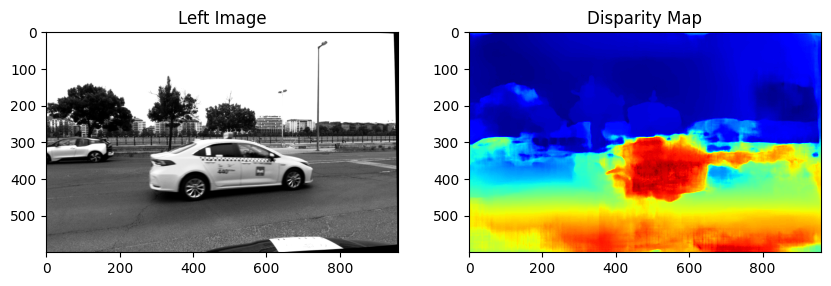

In [7]:
# im0_path = 'middlebury/im0.png'
# disp0_path = 'middlebury/disp0.png'
# im0_path = 'middlebury/piano.png'
# disp0_path = 'middlebury/piano.pfm'
im0_path = '../1_vanishing_point_est/SuperGluePretrainedNetwork/rectified/dev0/Dev0_Image_w1920_h1200_fn457.jpg'
# im0_path = '../1_vanishing_point_est/SuperGluePretrainedNetwork/rect_results/dev1/final1_pair_0.png'
disp0_path = '../depth_estimation_stereo_images/results/Dev0_Image_w1920_h1200_fn457_disp.png'


im0 = cv2.imread(im0_path, cv2.IMREAD_GRAYSCALE)  
disp0 = cv2.imread(disp0_path, cv2.IMREAD_UNCHANGED)  

disp0 = cv2.resize(disp0, (960, 600), interpolation=cv2.INTER_LINEAR)
# 
disp0 = disp0.astype(np.float32)

# disp0_display = (disp0 - disp0.min()) / (disp0.max() - disp0.min())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Left Image")
plt.imshow(im0, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Disparity Map")
plt.imshow(disp0, cmap='jet')
plt.savefig("left_img_and_disp.png")
plt.show()

## 3D position from disparity

In [108]:
positions = np.zeros((height, width, 3), dtype=np.float32)
point_cloud = np.zeros((height, width, 3), dtype=np.float32)

for i in range(height):
    for j in range(width):
        d = disp0[i, j] + doffs
        if d > 0: 
            Z = fx * baseline / d
            X = (j - cx) * Z / fx
            Y = (i - cy) * Z / fy
            positions[i, j] = [X, Y, Z]
            point_cloud[i, j] = [X, Y, Z]

print(f"Positions array shape: {positions.shape}")
# print(positions)

Positions array shape: (600, 960, 3)


## Edge Detectors

In [109]:
def compute_canny_weights(image, low_threshold=70, high_threshold=100):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    weights = edges.astype(np.float32) / 255.0
    return weights

def compute_sobel_weights(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    weights = sobel.astype(np.float32) / sobel.max()
    return weights

def compute_log_weights(image):
    log = cv2.Laplacian(image, cv2.CV_64F, ksize=5)
    weights = np.abs(log).astype(np.float32) / np.abs(log).max()
    return weights

def compute_harris_weights(image):
    gray = np.float32(image)
    harris_corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    harris_corners = cv2.dilate(harris_corners, None)
    weights = harris_corners / harris_corners.max()
    return weights

def compute_prewitt_weights(image):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=int)
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=int)
    prewitt_x = cv2.filter2D(image, -1, kernelx)
    prewitt_y = cv2.filter2D(image, -1, kernely)
    prewitt = np.sqrt(prewitt_x**2 + prewitt_y**2)
    weights = prewitt.astype(np.float32) / prewitt.max()
    return weights

def compute_scharr_weights(image):
    scharr_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
    scharr_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)
    scharr = np.sqrt(scharr_x**2 + scharr_y**2)
    weights = scharr.astype(np.float32) / scharr.max()
    return weights

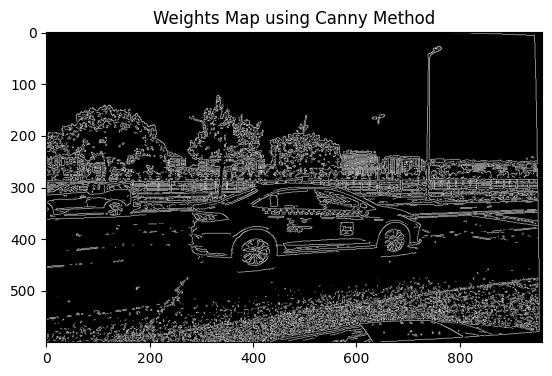

In [110]:
def get_weights_map(image, mode='canny'):
    switcher = {
        'canny': compute_canny_weights,
        'sobel': compute_sobel_weights,
        'log': compute_log_weights,
        'harris': compute_harris_weights,
        'prewitt': compute_prewitt_weights,
        'scharr': compute_scharr_weights
    }
    func = switcher.get(mode, compute_canny_weights)
    return func(image)

# mode: 'canny', 'sobel', 'log', 'harris', 'prewitt', 'scharr'
selected_mode = 'canny'  

weights_map = get_weights_map(im0, selected_mode)
plt.imshow(weights_map, cmap='gray')
plt.title(f'Weights Map using {selected_mode.capitalize()} Method')
plt.savefig("weights_map_canny.png")
plt.show()

## Main (Mode)

In [111]:
import time
affine_params = np.zeros((height, width, 2), dtype=np.float32)
pxsize = np.array([1.0/width, 1.0/height], dtype=np.float32)
mode = 3 
depth = positions[:, :, 2]
start_time = time.time()

for i in range(height):
    for j in range(width):
        uv = np.array([(j + 0.5) / width, (i + 0.5) / height], dtype=np.float32)
        
        
        if mode == 0:
            affine = affine_nb(uv, pxsize, im0, disp0)
        elif mode == 1:
            affine = affine_lsq(uv, pxsize, disp0)
        elif mode == 2:
            affine = adaptive_affine_cumulative_error_lsq(uv, pxsize, im0, disp0, weights_map)
        elif mode == 3:
            # depth  = positions[i, j, 2] 
            affine = adaptive_affine_lsq_min_max(uv, pxsize, im0, disp0, depth) #CD
                
        elif mode == 4:
            depth  = positions[i, j, 2] 
            # print(depth)
            affine = adaptive_affine_angular_threshold(uv, pxsize, im0, disp0, positions) #CD
        elif mode == 5:
            affine = adaptive_affine_simple_threshold(uv, pxsize, im0, disp0, weights_map)

        affine_params[i, j] = affine
            
    if ((i + 1) % 50 == 0 or i == height - 1):
        elapsed = time.time() - start_time
        print(f"Row {i+1}/{height} complete — elapsed {elapsed:.1f}s")

Row 50/600 complete — elapsed 159.3s
Row 100/600 complete — elapsed 326.4s
Row 150/600 complete — elapsed 492.1s
Row 200/600 complete — elapsed 655.5s
Row 250/600 complete — elapsed 816.9s
Row 300/600 complete — elapsed 964.7s
Row 350/600 complete — elapsed 1111.2s
Row 400/600 complete — elapsed 1271.6s
Row 450/600 complete — elapsed 1433.1s
Row 500/600 complete — elapsed 1603.3s
Row 550/600 complete — elapsed 1772.7s
Row 600/600 complete — elapsed 1936.1s


In [112]:
print(affine_params.shape)
np.save('affine_params.npy', affine_params)
print("Saved affine_params to affine_params.npy")
# print(affine_params)

(600, 960, 2)
Saved affine_params to affine_params.npy


In [113]:
# Load the array from disk
affine_params = np.load('affine_params.npy')

# Check its shape (should match what you saved)
print(affine_params.shape)

# (Optional) Inspect some values
print(affine_params[:500, :500])    # first two rows, first five columns


(600, 960, 2)
[[[ 2.569267    2.4237483 ]
  [ 1.3517358   2.9265783 ]
  [-2.1174943   3.3701966 ]
  ...
  [ 1.1838847   2.113081  ]
  [ 1.5436198   2.1889555 ]
  [ 1.184354    1.994861  ]]

 [[ 2.156607    3.5603254 ]
  [ 0.7190798   3.9298234 ]
  [-1.7255989   4.5888863 ]
  ...
  [ 1.0042273   1.7932827 ]
  [ 0.25849423  0.6935722 ]
  [ 0.9082292   2.5199482 ]]

 [[ 1.3154564   4.8095493 ]
  [ 0.6243132   5.2745852 ]
  [-0.7601263   4.0766907 ]
  ...
  [ 0.82417196  0.11756523]
  [ 0.5398455  -0.0389005 ]
  [ 0.6911688   0.16840976]]

 ...

 [[ 2.713717   -0.23083384]
  [ 1.7232126  -0.52387047]
  [ 0.684508   -0.15034322]
  ...
  [ 0.3515085  -0.52712643]
  [ 0.51313835 -0.6887684 ]
  [ 0.20508344 -0.5656978 ]]

 [[ 2.6311405  -0.3506711 ]
  [ 1.5356603  -0.72328305]
  [ 0.43875587 -0.41863358]
  ...
  [ 0.3551523  -0.72507983]
  [ 0.4786477  -0.797197  ]
  [ 0.14249703 -0.63602954]]

 [[ 2.7554517  -0.53927994]
  [ 1.6136096  -0.89200693]
  [ 0.49434265 -0.5849286 ]
  ...
  [ 0.6261

## Synthetic Testing

In [ ]:
import numpy as np

# --------------------------
# 1) Synthetic scene & intrinsics
# --------------------------
H, W = 100, 120
fx, fy = 600.0, 600.0
cx, cy = (W - 1) / 2.0, (H - 1) / 2.0
baseline = 0.1  # meters

# A simple tilted plane in front of the camera (depth in meters)
u_lin = np.linspace(0, 1, W, dtype=np.float32)
v_lin = np.linspace(0, 1, H, dtype=np.float32)
uu, vv = np.meshgrid(u_lin, v_lin)

# depth: Z = z0 + ax*U + ay*V  (U,V in [0,1])
z0, ax, ay = 2.0, 0.5, 0.3
depth_map = z0 + ax*uu + ay*vv  # shape (H, W)

# disparity (pinhole stereo): disp = f * B / Z
disp_map = (fx * baseline) / depth_map
disp_tex = np.zeros((H, W, 2), dtype=np.float32)
disp_tex[..., 0] = disp_map  # use .x channel like GLSL

# --------------------------
# 2) Reconstruct 3D positions (camera frame) from depth
# --------------------------
# pixel coords
xs = np.arange(W, dtype=np.float32)
ys = np.arange(H, dtype=np.float32)
xx, yy = np.meshgrid(xs, ys)  # pixel indices

Z = depth_map
X = (xx - cx) / fx * Z
Y = (yy - cy) / fy * Z
positions = np.stack([X, Y, Z], axis=-1).astype(np.float32)  # (H,W,3)

# --------------------------
# 3) Run your affine estimator over the grid
# --------------------------
pxsize = np.array([1.0/W, 1.0/H], dtype=np.float32)

affine_params = np.zeros((H, W, 2), dtype=np.float32)
for i in range(H):
    for j in range(W):
        uv = np.array([(j + 0.5)/W, (i + 0.5)/H], dtype=np.float32)
        affine_params[i, j] = adaptive_affine_lsq_min_max(uv, pxsize, None, disp_tex, depth_map)

# --------------------------
# 4A) Ground-truth normals from positions (cross-product)
# --------------------------
def normals_from_positions(pos):
    """
    pos: (H,W,3) camera-space points
    normal at (i,j) ~ normalize( (p(i,j+1)-p(i,j)) x (p(i+1,j)-p(i,j)) )
    Uses forward diffs and clamps at borders.
    """
    H, W, _ = pos.shape
    # neighbor differences (clamped at edges)
    p = pos
    p_right = np.roll(p, -1, axis=1)
    p_down  = np.roll(p, -1, axis=0)

    # avoid wrapping across edge by copying last column/row back
    p_right[:, -1, :] = p[:, -1, :]
    p_down[-1, :, :]  = p[-1, :, :]

    v_u = p_right - p   # along +x (image column)
    v_v = p_down  - p   # along +y (image row)

    n = np.cross(v_u, v_v)  # (H,W,3)
    # normalize
    norm = np.linalg.norm(n, axis=2, keepdims=True) + 1e-12
    n = n / norm

    # optional: make normals face the camera (+Z) consistently
    facing = np.sign(n[..., 2:3] + 1e-12)
    n = n * np.where(facing < 0, -1.0, 1.0)

    return n.astype(np.float32)

normals_gt = normals_from_positions(positions)  # ground truth from geometry

# --------------------------
# 4B) Estimated normals from your affine → normal formula
# --------------------------
normals_est = np.zeros((H, W, 3), dtype=np.float32)
for i in range(H):
    for j in range(W):
        a = affine_params[i, j]      # [a0, a1]
        p = positions[i, j]          # [X,Y,Z]

        # Your original mapping:
        x = baseline * fx * p[2] * (1.0 - a[0])
        y = baseline * fy * p[2] * a[1]
        z = baseline * (a[0] * fx * p[0] + a[1] * fy * p[1] + baseline * fx - fx * p[0])

        n = np.array([x, y, z], dtype=np.float32)
        ln = np.linalg.norm(n)
        if ln > 0:
            n /= ln

        # optional: enforce facing consistency to +Z like ground truth
        if n[2] < 0:
            n = -n

        normals_est[i, j] = n

# --------------------------
# 5) Quick sanity: compare fields numerically
# --------------------------
# cosine similarity map ([-1,1], closer to 1 is better)
dot = np.sum(normals_gt * normals_est, axis=2)
cos_sim = np.clip(dot, -1.0, 1.0)

print("Cosine similarity stats:",
      "min =", float(cos_sim.min()),
      "mean =", float(cos_sim.mean()),
      "max =", float(cos_sim.max()))

# For display in [0,1], like your normal_display
normal_display = (normals_est - normals_est.min()) / (normals_est.max() - normals_est.min() + 1e-12)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 1) Synthetic scene & intrinsics =====
H, W = 100, 120
fx, fy = 600.0, 600.0
cx, cy = (W - 1)/2.0, (H - 1)/2.0
baseline = 0.1

u_lin = np.linspace(0, 1, W, dtype=np.float32)
v_lin = np.linspace(0, 1, H, dtype=np.float32)
uu, vv = np.meshgrid(u_lin, v_lin)

z0, ax, ay = 2.0, 0.5, 0.3
depth_map = z0 + ax*uu + ay*vv

disp_map = (fx * baseline) / depth_map
disp_tex = np.zeros((H, W, 2), dtype=np.float32)
disp_tex[..., 0] = disp_map

# reconstruct positions
xs = np.arange(W, dtype=np.float32)
ys = np.arange(H, dtype=np.float32)
xx, yy = np.meshgrid(xs, ys)
Z = depth_map
X = (xx - cx) / fx * Z
Y = (yy - cy) / fy * Z
positions = np.stack([X, Y, Z], axis=-1).astype(np.float32)

# ===== 2) Affine estimation =====
pxsize = np.array([1.0/W, 1.0/H], dtype=np.float32)
affine_params = np.zeros((H, W, 2), dtype=np.float32)
for i in range(H):
    for j in range(W):
        uv = np.array([(j + 0.5)/W, (i + 0.5)/H], dtype=np.float32)
        affine_params[i, j] = adaptive_affine_lsq_min_max(uv, pxsize, None, disp_tex, depth_map)

# ===== 3) Normals: GT via cross product =====
def normals_from_positions(pos):
    H, W, _ = pos.shape
    p = pos
    pr = np.roll(p, -1, axis=1); pr[:, -1, :] = p[:, -1, :]
    pd = np.roll(p, -1, axis=0); pd[-1, :, :] = p[-1, :, :]
    vu = pr - p
    vv = pd - p
    n = np.cross(vu, vv)
    n /= (np.linalg.norm(n, axis=2, keepdims=True) + 1e-12)
    # make them face +Z
    n[n[...,2] < 0] *= -1.0
    return n.astype(np.float32)

normals_gt = normals_from_positions(positions)

# ===== 4) Normals: from your affine->normal mapping =====
normals_est = np.zeros((H, W, 3), dtype=np.float32)
for i in range(H):
    for j in range(W):
        a = affine_params[i, j]
        p = positions[i, j]
        x = -baseline * fx * p[2] * (1.0 - a[0])
        y = -baseline * fy * p[2] * a[1]
        z = baseline * (a[0]*fx*p[0] + a[1]*fy*p[1] + baseline*fx - fx*p[0])
        n = np.array([x, y, z], dtype=np.float32)
        ln = np.linalg.norm(n)
        if ln > 0: n /= ln
        if n[2] < 0: n = -n
        normals_est[i, j] = n

# ===== 5) Cosine similarity =====
dot = np.sum(normals_gt * normals_est, axis=2)
cos_sim = np.clip(dot, -1.0, 1.0)

print("Cosine similarity stats:",
      "min =", float(cos_sim.min()),
      "mean =", float(cos_sim.mean()),
      "max =", float(cos_sim.max()))

# ===== 6) Plot helpers =====
def plot_normals_over_depth(depth_map, normals, title, step=6, scale=25):
    depth_vis = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-12)
    H, W = depth_map.shape
    ys = np.arange(0, H, step)
    xs = np.arange(0, W, step)
    XS, YS = np.meshgrid(xs, ys)
    U = normals[ys[:,None], xs, 0]
    V = -normals[ys[:,None], xs, 1]  # flip y for image coords
    plt.figure()
    plt.imshow(depth_vis, origin='upper')
    plt.quiver(XS, YS, U, V, angles='xy', scale=scale)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ===== 7) Show the three figures =====
plot_normals_over_depth(depth_map, normals_gt,  "GT normals over depth")
plot_normals_over_depth(depth_map, normals_est, "Estimated normals over depth")

plt.figure()
plt.imshow(cos_sim, origin='upper', vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.title("Cosine similarity (GT · Est)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Normal

In [114]:
normals = np.zeros((height, width, 3), dtype=np.float32)

for i in range(height):
    for j in range(width):
        uv = np.array([j / width, i / height])
        a = affine_params[i, j]
        p = positions[i, j]

        x = baseline * fx * p[2] * (1 - a[0])
        y =  a[1] * baseline * fy * p[2] # I put -ve, check, dont need vector then appear upside down
        z = baseline * (a[0] * fx * p[0] + a[1] * fy * p[1] + baseline * fx - fx * p[0])

        normal = np.array([x, y, z])
        if np.linalg.norm(normal) != 0:
            normal = normal / np.linalg.norm(normal)
                
        normals[i, j] = normal

normal_display = (normals - normals.min()) / (normals.max() - normals.min())

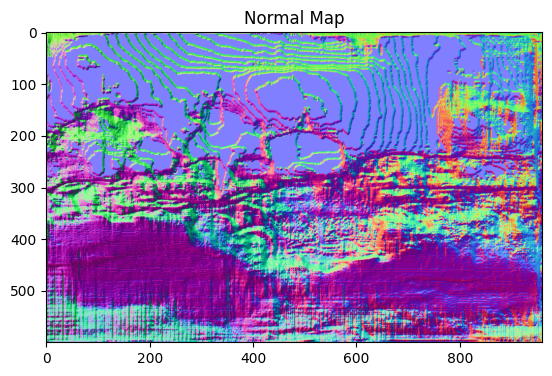

In [115]:
# print(normal_display)
# normal_display = np.flipud(normal_display)
plt.imshow(normal_display)
plt.title("Normal Map")
plt.savefig("normal_map.png")
plt.show()

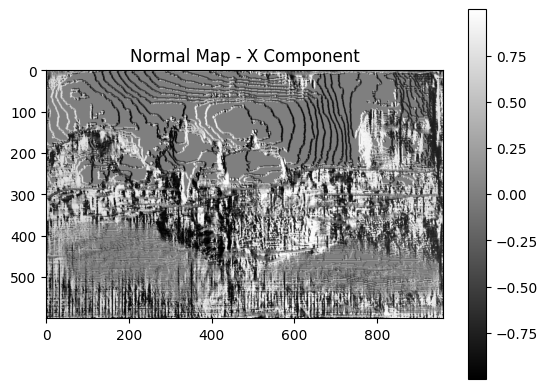

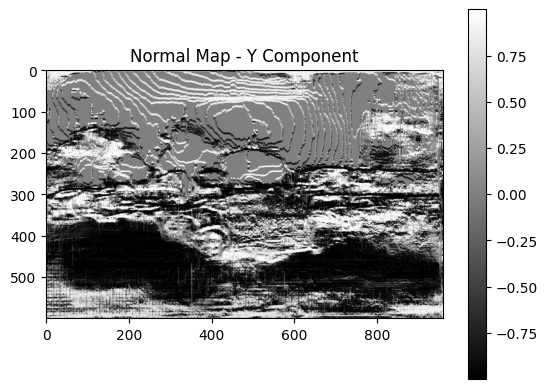

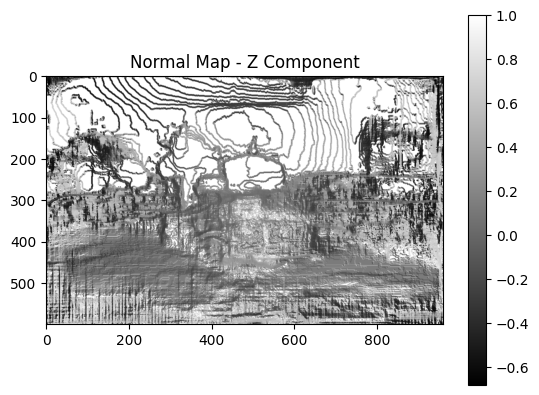

In [116]:
plt.figure()
plt.imshow(normals[..., 0], cmap='gray')
plt.title("Normal Map - X Component")
plt.colorbar()
plt.savefig("normal_map_x.png")
plt.show()

plt.figure()
plt.imshow(normals[..., 1], cmap='gray')
plt.title("Normal Map - Y Component")
plt.colorbar()
plt.savefig("normal_map_y.png")
plt.show()

plt.figure()
plt.imshow(normals[..., 2], cmap='gray')
plt.title("Normal Map - Z Component")
plt.colorbar()
plt.savefig("normal_map_z.png")
plt.show()

## Normals overlaid on Image

In [117]:
# image_path = 'middlebury/piano.png'
image_path = '../1_vanishing_point_est/SuperGluePretrainedNetwork/rectified/dev0/Dev0_Image_w1920_h1200_fn457.jpg'
# image_path = '../1_vanishing_point_est/SuperGluePretrainedNetwork/rect_results/right_rect/final2_pair_0.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

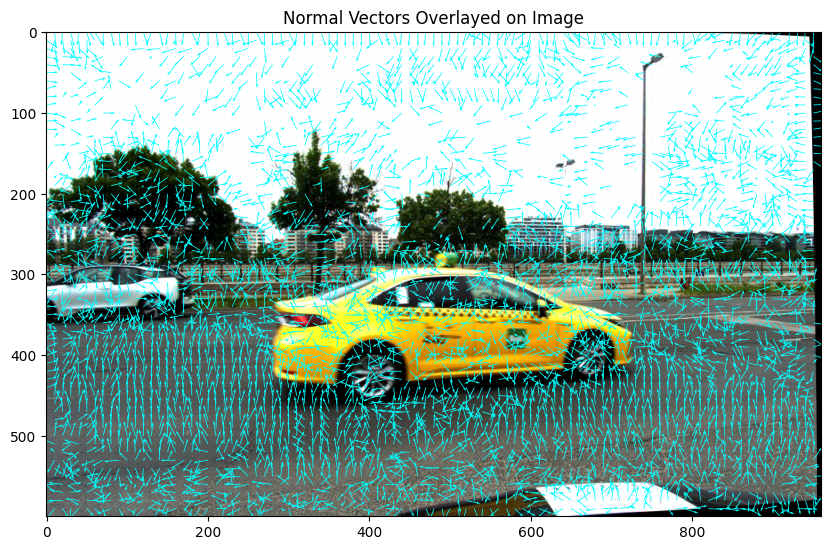

In [118]:
height, width, _ = normals.shape

step = 10
x, y = np.meshgrid(np.arange(0, width, step), np.arange(0, height, step))
u = normals[::step, ::step, 0]  # X component of normal vectors
v = normals[::step, ::step, 1]  # Y component of normal vectors

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Normal Vectors Overlayed on Image")

plt.quiver(x, y, u, -v, color='cyan', scale=50, width=0.001)  # Invert Y for correct orientation
plt.savefig("normal_overlaid.png")
plt.show()

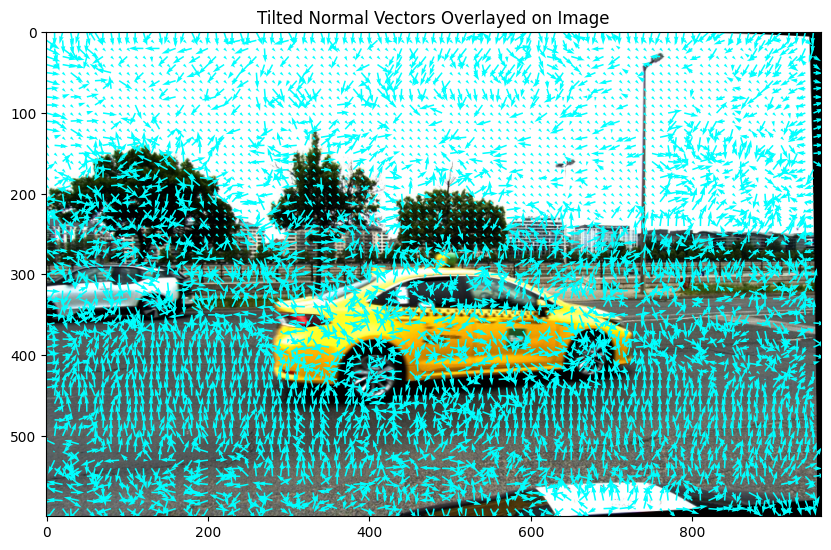

In [119]:
height, width, _ = normals.shape

step = 10
x, y = np.meshgrid(np.arange(0, width, step), np.arange(0, height, step))
u = normals[::step, ::step, 0]  # X component of normal vectors
v = normals[::step, ::step, 1]  # Y component of normal vectors (-ve factor we added)
w = normals[::step, ::step, 2]  # Z component of normal vectors

tilt_factor = 0.2  
u_tilted = u + tilt_factor * w
v_tilted = v + tilt_factor * w

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Tilted Normal Vectors Overlayed on Image")

plt.quiver(x, y, u_tilted, -v_tilted, color='cyan', scale=50, width=0.002)  # Invert Y for correct orientation
plt.savefig("normal_overlaid_tilted.png")
plt.show()

## 2nd Method to plot normals

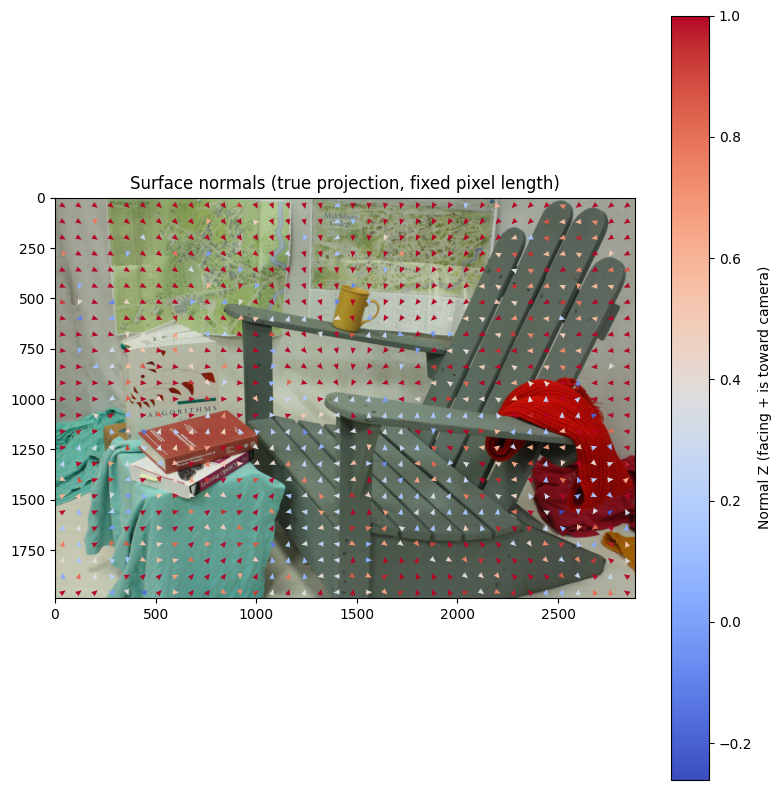

In [37]:
import numpy as np
import matplotlib.pyplot as plt


def project_point(P, fx, fy, cx, cy):
    X, Y, Z = P[...,0], P[...,1], P[...,2]
    # avoid divide-by-zero
    Z = np.clip(Z, 1e-6, None)
    u = fx * (X / Z) + cx
    v = fy * (Y / Z) + cy
    return u, v

def overlay_normals_quiver(image, positions, normals, fx, fy, cx, cy,
                           step=24, s_world=0.05, L_pixels=12,
                           cmap='coolwarm', show_back=True):
    """
    - s_world: 3D step along the normal (meters); only used to derive direction.
    - L_pixels: final fixed arrow length in pixels (for visibility).
    - show_back: if False, hide normals with n_z < 0.
    """
    H, W = image.shape[:2]

    # subsample grid
    ys = np.arange(step//2, H, step)
    xs = np.arange(step//2, W, step)
    XS, YS = np.meshgrid(xs, ys)

    P  = positions[YS, XS]          # (N,M,3)
    n  = normals[YS, XS]            # (N,M,3)

    # optionally hide back-facing
    if not show_back:
        mask = (n[...,2] >= 0).astype(float)[...,None]
        n = n * mask + (1-mask) * np.array([0,0,0], dtype=n.dtype)

    # project base and endpoint
    u0, v0 = project_point(P, fx, fy, cx, cy)
    P_end  = P + s_world * n
    u1, v1 = project_point(P_end, fx, fy, cx, cy)

    du = u1 - u0
    dv = v1 - v0

    # normalize 2D direction and rescale to fixed pixel length for visibility
    mag = np.sqrt(du*du + dv*dv) + 1e-12
    du = (du / mag) * L_pixels
    dv = (dv / mag) * L_pixels

    # color by Nz to convey “out of screen” vs “into screen”
    nz = n[...,2]
    # Matplotlib quiver can take an array for color
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    # Q = plt.quiver(XS, YS, du, dv, nz,  # note -dv to match image coordinates
    #                angles='xy', scale=1, scale_units='xy', width=0.003, cmap=cmap)
    Q = plt.quiver(
    XS, YS, du, dv, nz,
    angles='xy', scale_units='xy', scale=1,     # ← do NOT shrink after fixing length
    width=0.003, pivot='middle', minlength=0,   # ← always draw, nicer pivot
    headwidth=6, headlength=7, headaxislength=6,
    cmap=cmap
    )
    plt.colorbar(Q, label='Normal Z (facing + is toward camera)')
    # plt.gca().invert_yaxis()
    plt.title("Surface normals (true projection, fixed pixel length)")
    plt.tight_layout()
    plt.show() 

overlay_normals_quiver(image, positions, normals, fx, fy, cx, cy, step=80, s_world=0.1, L_pixels=32, cmap='coolwarm', show_back=True)


## 3D Reconstruction with normals

In [7]:
def write_ply(filename, points, normals=None, colors=None):
    """
    Write a PLY file with points, optional normals, and optional colors.
    
    Parameters:
        filename (str): Output PLY filename.
        points (numpy.ndarray): Array of shape (N, 3) containing 3D point coordinates.
        normals (numpy.ndarray, optional): Array of shape (N, 3) with normals.
        colors (numpy.ndarray, optional): Array of shape (N, 3) with RGB color values (0-255).
    """
    num_points = points.shape[0]
    with open(filename, "w") as ply_file:
        # Write header
        ply_file.write("ply\n")
        ply_file.write("format ascii 1.0\n")
        ply_file.write("element vertex {}\n".format(num_points))
        ply_file.write("property float x\n")
        ply_file.write("property float y\n")
        ply_file.write("property float z\n")
        if normals is not None:
            ply_file.write("property float nx\n")
            ply_file.write("property float ny\n")
            ply_file.write("property float nz\n")
        if colors is not None:
            ply_file.write("property uchar red\n")
            ply_file.write("property uchar green\n")
            ply_file.write("property uchar blue\n")
        ply_file.write("end_header\n")
        
        # Write vertex data with the available attributes
        if normals is not None and colors is not None:
            for point, normal, color in zip(points, normals, colors):
                ply_file.write("{:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {} {} {}\n".format(
                    point[0], point[1], point[2],
                    normal[0], normal[1], normal[2],
                    int(color[0]), int(color[1]), int(color[2])))
        elif normals is not None:
            for point, normal in zip(points, normals):
                ply_file.write("{:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f}\n".format(
                    point[0], point[1], point[2],
                    normal[0], normal[1], normal[2]))
        elif colors is not None:
            for point, color in zip(points, colors):
                ply_file.write("{:.6f} {:.6f} {:.6f} {} {} {}\n".format(
                    point[0], point[1], point[2],
                    int(color[0]), int(color[1]), int(color[2])))
        else:
            for point in points:
                ply_file.write("{:.6f} {:.6f} {:.6f}\n".format(point[0], point[1], point[2]))


In [39]:
points_flat = point_cloud.reshape(-1, 3)
normals_flat = normals.reshape(-1, 3)  # If you want to include normals
colors_flat = image.reshape(-1, 3)

# Write to a PLY file (this file will contain positions, normals, and colors)
write_ply("colored_point_cloud_with_normals.ply", points_flat, normals_flat, colors_flat)

## For All Disp Maps

In [ ]:
import glob
import time
import os

processed = 0
left_images = sorted(glob.glob("../1_vanishing_point_est/SuperGluePretrainedNetwork/rectified/dev0/*.jpg"))
disp_images  = sorted(glob.glob("../depth_estimation_stereo_images/results/*.png"))

for idx, (imfile1, dispfile) in enumerate(zip(left_images, disp_images), start=1):
    # skip every 10th frame
    if idx % 10 != 0:
        continue
    print(f" processing fn {idx}")
    # --- load & resize inputs ---
    im0 = cv2.imread(imfile1, cv2.IMREAD_GRAYSCALE)
    im_rgb = cv2.imread(imfile1)
    im_rgb = cv2.cvtColor(cv2.resize(im_rgb, (960, 600), interpolation=cv2.INTER_AREA), cv2.COLOR_BGR2RGB)

    disp0 = cv2.imread(dispfile, cv2.IMREAD_UNCHANGED)
    disp0 = cv2.resize(disp0, (960, 600), interpolation=cv2.INTER_LINEAR)

    height, width = disp0.shape[:2]

    # --- allocate ---
    positions   = np.zeros((height, width, 3), dtype=np.float32)
    point_cloud = np.zeros((height, width, 3), dtype=np.float32)

    # --- positions from disparity ---
    for i in range(height):
        for j in range(width):
            d = disp0[i, j] + doffs
            if d > 0:
                Z = fx * baseline / d
                X = (j - cx) * Z / fx
                Y = (i - cy) * Z / fy
                positions[i, j] = [X, Y, Z]
                point_cloud[i, j] = [X, Y, Z]

    # --- affine params ---
    affine_params = np.zeros((height, width, 2), dtype=np.float32)
    pxsize = np.array([1.0/width, 1.0/height], dtype=np.float32)
    mode = 3
    depth = positions[:, :, 2]
    start_time = time.time()

    for i in range(height):
        for j in range(width):
            uv = np.array([(j + 0.5) / width, (i + 0.5) / height], dtype=np.float32)
            if mode == 3:
                affine = adaptive_affine_lsq_min_max(uv, pxsize, im0, disp0, depth)
            affine_params[i, j] = affine

    npy_name = os.path.splitext(os.path.basename(imfile1))[0] + "_affine.npy"
    np.save(npy_name, affine_params)

    # --- normals ---
    normals = np.zeros((height, width, 3), dtype=np.float32)
    for i in range(height):
        for j in range(width):
            uv = np.array([j / width, i / height])
            a = affine_params[i, j]
            p = positions[i, j]

            x = baseline * fx * p[2] * (1 - a[0])
            y = a[1] * baseline * fy * p[2]
            z = baseline * (a[0] * fx * p[0] + a[1] * fy * p[1] + baseline * fx - fx * p[0])

            normal = np.array([x, y, z])
            nrm = np.linalg.norm(normal)
            if nrm != 0:
                normal = normal / nrm
            normals[i, j] = normal

    # --- write PLY (keep only points with valid disparity) ---
    valid_mask = (disp0 > 0).reshape(-1)
    points_flat  = point_cloud.reshape(-1, 3)[valid_mask]
    normals_flat = normals.reshape(-1, 3)[valid_mask]
    colors_flat  = im_rgb.reshape(-1, 3)[valid_mask]

    ply_name = os.path.splitext(os.path.basename(imfile1))[0] + ".ply"
    write_ply(ply_name, points_flat, normals_flat, colors_flat)

    processed += 1
    if processed % 10 == 0:
        print(f"processed {processed} done")


 processing fn 10
 processing fn 20
 processing fn 30
 processing fn 40
 processing fn 50
 processing fn 60
 processing fn 70
 processing fn 80
 processing fn 90
 processing fn 100
processed 10 done
 processing fn 110
 processing fn 120
 processing fn 130
 processing fn 140
 processing fn 150
 processing fn 160
 processing fn 170
 processing fn 180
 processing fn 190
 processing fn 200
processed 20 done
 processing fn 210
 processing fn 220
 processing fn 230
 processing fn 240
 processing fn 250
 processing fn 260
 processing fn 270
 processing fn 280
 processing fn 290
 processing fn 300
processed 30 done
 processing fn 310
 processing fn 320
 processing fn 330
 processing fn 340
 processing fn 350
 processing fn 360


In [8]:
import os
positions = np.zeros((height, width, 3), dtype=np.float32)
point_cloud = np.zeros((height, width, 3), dtype=np.float32)
normals = np.zeros((height, width, 3), dtype=np.float32)
outdir = "results"
os.makedirs(outdir, exist_ok=True) 

for fn in range(109, 460, 10):
    print(f"=== Processing fn {fn} ===")

    # paths for this frame (reuse same variable names)
    im0_path   = f"../1_vanishing_point_est/SuperGluePretrainedNetwork/rectified/dev0/Dev0_Image_w1920_h1200_fn{fn}.jpg"
    disp0_path = f"../depth_estimation_stereo_images/results/Dev0_Image_w1920_h1200_fn{fn}_disp.png"

    im0   = cv2.imread(im0_path, cv2.IMREAD_GRAYSCALE)
    disp0 = cv2.imread(disp0_path, cv2.IMREAD_UNCHANGED)

    disp0 = cv2.resize(disp0, (960, 600), interpolation=cv2.INTER_LINEAR)
    disp0 = disp0.astype(np.float32)

    affine_params = np.load(f"Dev0_Image_w1920_h1200_fn{fn}_affine.npy")

    # recompute positions and point cloud (reuse same arrays)
    positions[:]   = 0
    point_cloud[:] = 0
    for i in range(height):
        for j in range(width):
            d = disp0[i, j] + doffs
            if d > 0:
                Z = fx * baseline / d
                X = (j - cx) * Z / fx
                Y = (i - cy) * Z / fy
                positions[i, j]   = [X, Y, Z]
                point_cloud[i, j] = [X, Y, Z]

    print(f"Positions array shape: {positions.shape}")

    # recompute normals (reuse same array)
    normals[:] = 0
    for i in range(height):
        for j in range(width):
            uv = np.array([j / width, i / height])
            a  = affine_params[i, j]
            p  = positions[i, j]

            x = baseline * fx * p[2] * (1 - a[0])
            y = a[1] * baseline * fy * p[2]
            z = baseline * (a[0] * fx * p[0] + a[1] * fy * p[1] + baseline * fx - fx * p[0])

            normal = np.array([x, y, z])
            nrm = np.linalg.norm(normal)
            if nrm != 0:
                normal = normal / nrm
            normals[i, j] = normal

    # normal map image
    normal_display = (normals - normals.min()) / (normals.max() - normals.min())
    plt.imshow(normal_display)
    plt.title("Normal Map")
    plt.savefig(os.path.join(outdir, f"{fn}_normal_map_fn.png"))
    plt.close()

    # overlay (reuse image_path, image)
    image_path = im0_path
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width, _ = normals.shape
    step = 10
    x, y = np.meshgrid(np.arange(0, width, step), np.arange(0, height, step))
    u = normals[::step, ::step, 0]
    v = normals[::step, ::step, 1]

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Normal Vectors Overlayed on Image")
    plt.quiver(x, y, u, -v, color='cyan', scale=50, width=0.001)
    plt.savefig(os.path.join(outdir, f"{fn}_normal_overlaid_fn.png"))
    plt.close()

    # tilted overlay
    height, width, _ = normals.shape
    step = 10
    x, y = np.meshgrid(np.arange(0, width, step), np.arange(0, height, step))
    u = normals[::step, ::step, 0]
    v = normals[::step, ::step, 1]
    w = normals[::step, ::step, 2]

    tilt_factor = 0.2
    u_tilted = u + tilt_factor * w
    v_tilted = v + tilt_factor * w

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Tilted Normal Vectors Overlayed on Image")
    plt.quiver(x, y, u_tilted, -v_tilted, color='cyan', scale=50, width=0.002)
    plt.savefig(os.path.join(outdir, f"{fn}_normal_overlaid_tilted_fn.png"))
    plt.close()

    # also save the RGB and disparity used for this frame
    cv2.imwrite(os.path.join(outdir, f"{fn}_rgb_fn.png"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(os.path.join(outdir, f"disp_fn{fn}.png", cmap='jet'), disp0.astype(np.uint16))
    disp_vis = cv2.normalize(disp0, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = disp_vis.astype(np.uint8)
    
    # Apply JET colormap
    disp_color = cv2.applyColorMap(disp_vis, cv2.COLORMAP_JET)
    
    # Save
    cv2.imwrite(os.path.join(outdir, f"{fn}_disp_fn.png"), disp_color)

    print(f"✓ Saved outputs for fn {fn}")


=== Processing fn 109 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 109
=== Processing fn 119 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 119
=== Processing fn 129 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 129
=== Processing fn 139 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 139
=== Processing fn 149 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 149
=== Processing fn 159 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 159
=== Processing fn 169 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 169
=== Processing fn 179 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 179
=== Processing fn 189 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 189
=== Processing fn 199 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 199
=== Processing fn 209 ===
Positions array shape: (600, 960, 3)
✓ Saved outputs for fn 209
=== Proces